## Modelo ARCH/GARCH con las Bolsas de Valores más importantes del mundo
_Mauricio Alvarado_

En este proyecto, se buscará estimar los modelos que mejor se ajusten a las 5 principales Bolsas de Valores del mundo. Se usará la `S&P 500`, `Dow Jones`, `Nasdaq`, `Nikkei` y `HSI`. Las principales liberías que van a ser usadas son `yfinance`, `arch` y `statsmodels`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

# pip install arch 
from sklearn.linear_model import LinearRegression
from arch import arch_model
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_white, het_arch

import warnings
warnings.simplefilter("ignore")

Se crea un diccionario que englobe el nombre de la bolsa junto a _Ticker_

In [2]:
stocke = {"^GSPC": "S&P 500",
          "DJI": "Dow Jones",
          "^IXIC": "Nasdaq",
          "^N225": "Nikkei",
          "^HSI": "HSI"}

stocke_keys = list(stocke.keys())
stocke_name = list(stocke.values())

Se realizará la importación mediante la libería de Yahoo Finance: `yfinance`

In [3]:
data = pd.DataFrame()

for key in stocke_keys:
    stocke_data = yf.Ticker(key)
    stocke_data = stocke_data.history(period="max")
    stocke_data.reset_index(inplace=True)
    
    stocke_data[key] = stocke_data.Close

    if data.empty is True:
        data = pd.concat([data, stocke_data[["Date", key]]])
    else:
        data = pd.merge(data, stocke_data[["Date", key]], how="left")

Se realiza una limpieza y selección de los años a ser usados: entre `1990` y `2020`

In [4]:
data = data.dropna()
data = data.rename(stocke, axis=1)
data = data.set_index("Date")

# Fechas seleccionadas
data = data.loc[(data.index > '1990-01-01') & (data.index <= '2020-01-01')]

Se procede a crear los retornos de las bolsas y también a aproximar la volatilidad mediante los retornos al cuadrado

In [5]:
Y = (np.log(data)-np.log(data).shift(1))*100
Y = Y.dropna()
volat = Y**2


Y.head()

,S&P 500,Dow Jones,Nasdaq,Nikkei,HSI
Date,,,,,
1990-01-05,-0.980414,-0.819855,-0.261548,-1.138162,-0.984612
1990-01-08,0.450431,0.758680,0.109063,0.052760,-0.845137
1990-01-09,-1.185670,-1.020449,-0.415080,-0.901032,0.212842
1990-01-10,-0.662909,-0.556866,-1.344367,-0.674044,1.616907
1990-01-11,0.350656,0.363980,-0.400182,1.248568,-0.454308


### Previsualización de los datos

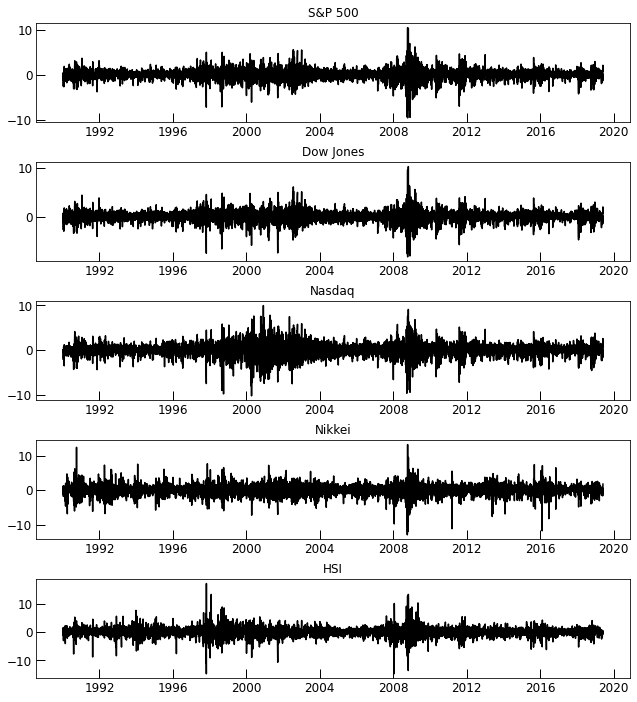

In [6]:
plt.figure(figsize=(15,13))

for i in enumerate(stocke_name):
    ax = plt.subplot(5, 1, i[0]+1)
    plt.plot(Y.index, Y[i[1]], color="black")
    plt.title(i[1])
    ax.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

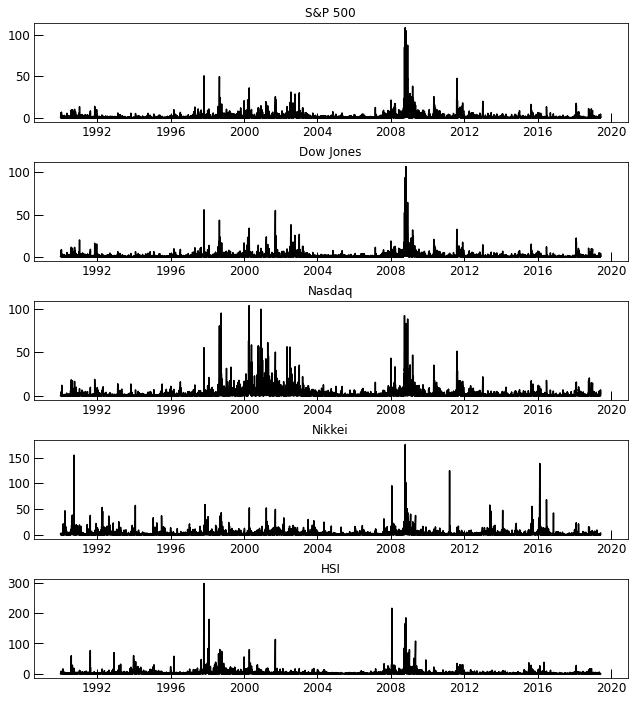

In [7]:
plt.figure(figsize=(15,13))

for i in enumerate(stocke_name):
    ax = plt.subplot(5, 1, i[0]+1)
    plt.plot(volat.index, volat[i[1]], color="black")
    plt.title(i[1])
    ax.tick_params(direction='in', which='both', length=9, width=1, labelsize=12)
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

### Hechos estilizados de las series financieras

El primero es `No autocorrelación en los retornos` ($\rho = 0$)

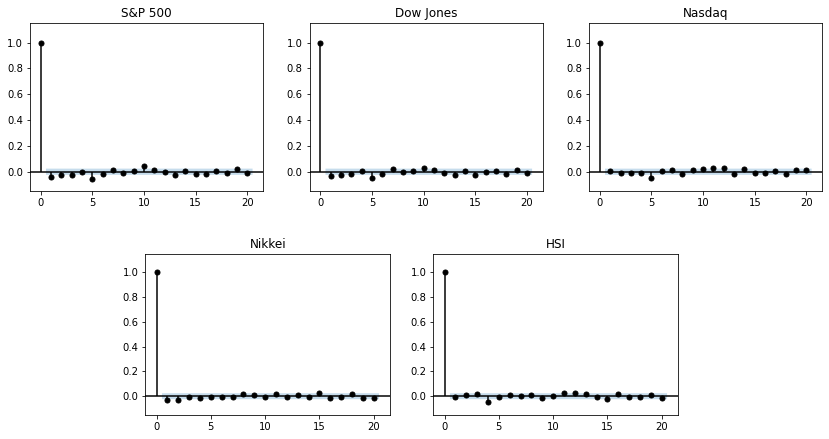

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
ax[1][2].set_visible(False) # No habrá 6to subplot

x, y = [0, 0]

for i in stocke_name:
    plot_acf(Y[i], lags=20, ax=ax[x, y], color="black", vlines_kwargs={"colors": "black"})
    ax[x, y].set_ylim(-0.15, 1.15)
    ax[x, y].set_title(i)
    
    y += 1
    if y == 3:
        x+=1
        y=0

plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

# Posiciones de los subplots de la segunda fila
ax[1, 0].set_position([0.28, 0.12, 0.17, 0.28]) 
ax[1, 1].set_position([0.48, 0.12, 0.17, 0.28])

plt.show()

El segundo: `Autocorrelación en los retornos al cuadrado` / volatilidad

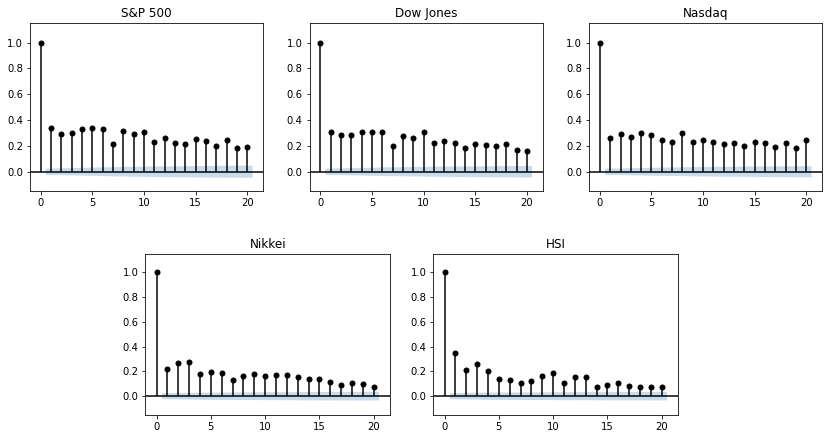

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
ax[1, 2].set_visible(False) # No habrá 6to subplot

x, y = [0, 0]

for i in stocke_name:
    plot_acf(volat[i], lags=20, ax=ax[x, y], color="black", vlines_kwargs={"colors": "black"})
    ax[x, y].set_ylim(-0.15, 1.15)
    ax[x, y].set_title(i)
    
    y += 1
    if y == 3:
        x+=1
        y=0

plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

# Posiciones de los subplots de la segunda fila
ax[1, 0].set_position([0.28, 0.12, 0.17, 0.28])
ax[1, 1].set_position([0.48, 0.12, 0.17, 0.28])

plt.show()

### Determinar la presencia de efectos ARCH
Para estimar un modelo ARCH o un modelo GARCH, es necesario primero determinar si los rendimientos presentar "efectos ARCH". Es decir, debemos estimar si existe heterocedasticidad en los retornos. Para ello, se puede usar cualquiera de estos test:

1. Test de White
2. Test de Engle
3. Test de Ljung-Box
4. Test de Breusch-Pagan

Se estimará mediante el `Test de White` y luego se corroborá con el `Test de Engle`

In [10]:
for i in stocke_name:
    y = Y[i]
    x = Y[i].shift(1)
    x = sm.add_constant(x)
    
    # Al hacer shift, perdemos una observación, así que:
    x = x.iloc[1:]
    y = y.iloc[1:]
    
    # Estimación
    model = sm.OLS(y, x).fit()
    white_test = het_white(model.resid, model.model.exog) #Test de White
    engle_test = het_arch(model.resid) #Test de Engle
    
    print(f"Para {i} el Test de White arroja un test-estadístio {np.round(white_test[0], 3)} con un p-value de {np.round(white_test[1], 3)}")
    print(f"Para {i} el Test de Engle arroja un test-estadístio {np.round(engle_test[0], 3)} con un p-value de {np.round(engle_test[1], 3)}\n")

Para S&P 500 el Test de White arroja un test-estadístio 712.558 con un p-value de 0.0
Para S&P 500 el Test de Engle arroja un test-estadístio 1756.464 con un p-value de 0.0

Para Dow Jones el Test de White arroja un test-estadístio 607.556 con un p-value de 0.0
Para Dow Jones el Test de Engle arroja un test-estadístio 1580.336 con un p-value de 0.0

Para Nasdaq el Test de White arroja un test-estadístio 500.414 con un p-value de 0.0
Para Nasdaq el Test de Engle arroja un test-estadístio 1430.042 con un p-value de 0.0

Para Nikkei el Test de White arroja un test-estadístio 337.526 con un p-value de 0.0
Para Nikkei el Test de Engle arroja un test-estadístio 1027.478 con un p-value de 0.0

Para HSI el Test de White arroja un test-estadístio 938.694 con un p-value de 0.0
Para HSI el Test de Engle arroja un test-estadístio 1191.208 con un p-value de 0.0



El Test de White y el test de Engle tienen como hipótesis nula que existe homocedasticidad. Por ende, en base a los resultados presentados arriba, se puede decir que -en todos los casos- se rechaza la hipótesis nula. Existe presencia de efectos ARCH en todas las series, y es necesario crear un modelo con heterocedasticidad condicional

### Estimando el modelo ARCH/GARCH

Un modelo ARCH tiene, según la propuesta de Robert Engle, un modelo autorregresivo de orden adecuado en los cuadrados de los errores del proceso $y_t$, dado por:
$$
y_t = \phi_0 + \phi_1 y_{t-1} + \epsilon_t
$$

Donde la varianza de condicional de los errroes $\epsilon_t$ dada la información en $\Omega_{t-1}$:
$$
Var(\epsilon_t/\Omega_{t-1}) = E(\epsilon^2_t/\Omega_{t-1}) = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ ... + \alpha_m \epsilon^2_{t-m}
$$

Del que surge del proceso: 
$$
\epsilon^2_{t} = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ ... + \alpha_m \epsilon^2_{t-m} + V_t
$$

Mediante iteraciones hacia el futuro, se puede construir la siguiente ecuación:
$$
\epsilon_{t} = V_t \sqrt((\alpha_0 + \alpha_1 \epsilon^2_{t-1} + \alpha_2 \epsilon^2_{t-2}+ ... + \alpha_m \epsilon^2_{t-m}))
$$

Finalmente, se construye las dos ecuaciones del modelo:
$$
\epsilon_{t} =  V_t \sqrt(h_t)
$$

$$
h_{t} = \alpha_0 + \sum^{m}_{i=1} \alpha_i \epsilon^2_{t-i}
$$

La importancia de usar -también- un modelo GARCH es que un modelo GARCH(1, 1) se puede aproximar como un ARCH($\inf$)

### Estimando un modelo para S&P 500

Primero, se debe estimar cada uno de los modelos para obtener sus resultados, y por ende los criterios de AIC y BIC. En primer lugar, se estimará un modelo ARCH(1)

In [11]:
arch_1 = arch_model(Y["S&P 500"], p=1, q=0)
arch_1_fit = arch_1.fit(disp=0)
print(arch_1_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9992.37
Distribution:                  Normal   AIC:                           19990.7
Method:            Maximum Likelihood   BIC:                           20011.2
                                        No. Observations:                 6684
Date:                Mon, Jul 25 2022   Df Residuals:                     6683
Time:                        14:18:24   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0397  1.421e-02      2.796  5.181e-03 [1.

### Criterios de información (AIC, BIC)

Tras la estimación del modelo, se puede extraer los criterios de información de AIC y BIC. El objetivo es estimar el modelo con menor criterio de información, el cual será el modelo elegido

In [12]:
print(f"AIC para ARCH(1): {np.round(arch_1_fit.aic, 3)}")
print(f"BIC para ARCH(1): {np.round(arch_1_fit.bic, 3)}")

AIC para ARCH(1): 19990.742
BIC para ARCH(1): 20011.165


### Funciones que estimen el mejor modelo para todas las bolsas
Como estimar cada modelo hasta llegar a uno correcto puede llegar a ser engorroso, es más factible crear una función que estime los resultados para cada una de las series:

In [13]:
def model_election(var):
    arch_1_fit = arch_model(Y[var], p=1, q=0).fit(disp=0)
    arch_2_fit = arch_model(Y[var], p=2, q=0).fit(disp=0)
    arch_3_fit = arch_model(Y[var], p=3, q=0).fit(disp=0)
    arch_4_fit = arch_model(Y[var], p=4, q=0).fit(disp=0)
    arch_5_fit = arch_model(Y[var], p=5, q=0).fit(disp=0)
    garch_11_fit = arch_model(Y[var], p=1, q=1).fit(disp=0)
    garch_12_fit = arch_model(Y[var], p=1, q=2).fit(disp=0)
    garch_21_fit = arch_model(Y[var], p=2, q=1).fit(disp=0)
    garch_22_fit = arch_model(Y[var], p=2, q=2).fit(disp=0)
    
    
    aic_models = {"ARCH(1)": arch_1_fit.aic,
                  "ARCH(2)": arch_2_fit.aic,
                  "ARCH(3)": arch_3_fit.aic,
                  "ARCH(4)": arch_4_fit.aic,
                  "ARCH(5)": arch_5_fit.aic,
                  "GARCH(1, 1)": garch_11_fit.aic,
                  "GARCH(1, 2)": garch_12_fit.aic,
                  "GARCH(2, 1)": garch_21_fit.aic,
                  "GARCH(2, 2)": garch_22_fit.aic}
    
    bic_models = {"ARCH(1)": arch_1_fit.bic,
                  "ARCH(2)": arch_2_fit.bic,
                  "ARCH(3)": arch_3_fit.bic,
                  "ARCH(4)": arch_4_fit.bic,
                  "ARCH(5)": arch_5_fit.bic,
                  "GARCH(1, 1)": garch_11_fit.bic,
                  "GARCH(1, 2)": garch_12_fit.bic,
                  "GARCH(2, 1)": garch_21_fit.bic,
                  "GARCH(2, 2)": garch_22_fit.bic}    
    
    aic_selected = None
    bic_selected = None
    
    for i in aic_models.keys():
        if aic_selected == None:
            aic_selected = aic_models[i]
            aic_model = i
        else:
            x = aic_models[i]
            if aic_selected > x:
                aic_selected = x
                aic_model = i
        
    for i in bic_models.keys():
        if bic_selected == None:
            bic_selected = bic_models[i]
            bic_model = i
        else:
            x = bic_models[i]
            if bic_selected > x:
                bic_selected = x
                bic_model = i
    
    return print(f"El menor AIC es {aic_selected} que corresponde al modelo {aic_model}. Para el BIC es {bic_selected} que corresponde al modelo {bic_model}")

In [14]:
model_election("S&P 500")

El menor AIC es 18182.992248749862 que corresponde al modelo GARCH(2, 2). Para el BIC es 18215.547295186014 que corresponde al modelo GARCH(1, 1)


In [15]:
model_election("Dow Jones")

El menor AIC es 17890.57607459542 que corresponde al modelo GARCH(2, 2). Para el BIC es 17920.089378336095 que corresponde al modelo GARCH(1, 1)


In [16]:
model_election("Nasdaq")

El menor AIC es 21408.61416724573 que corresponde al modelo GARCH(2, 1). Para el BIC es 21436.166387076286 que corresponde al modelo GARCH(1, 1)


In [17]:
model_election("Nikkei")

El menor AIC es 23511.219979480396 que corresponde al modelo GARCH(1, 1). Para el BIC es 23538.449867039257 que corresponde al modelo GARCH(1, 1)


In [18]:
model_election("HSI")

El menor AIC es 23262.286909061822 que corresponde al modelo GARCH(1, 1). Para el BIC es 23289.516796620683 que corresponde al modelo GARCH(1, 1)


En base a estos resultados, se tiene que tanto para `Nikkei` como para `HSI` es mejor usar un modelo GARCH(1, 1), debido a que los resultados son consistentes en los dos criterios de información. No obstante, para los otros tres se encuentran resultados diferentes. Debido a que la indecisión está entre qué modelo GARCH usar, se puede crear una función más que solo me dé los resultados de los criterios para todos los modelos GARCH. En base a la observación y -con poco de lógica- se decidirá qué modelo usar

In [19]:
def criterios_inf_garch(var):
    garch_11_fit = arch_model(Y[var], p=1, q=1).fit(disp=0)
    garch_12_fit = arch_model(Y[var], p=1, q=2).fit(disp=0)
    garch_21_fit = arch_model(Y[var], p=2, q=1).fit(disp=0)
    garch_22_fit = arch_model(Y[var], p=2, q=2).fit(disp=0)
    
    return print("Los criterios de información de AIC:\n " \
    f"GARCH(1, 1): {garch_11_fit.aic}\n " \
    f"GARCH(1, 2): {garch_12_fit.aic}\n " \
    f"GARCH(2, 1): {garch_21_fit.aic}\n " \
    f"GARCH(2, 2): {garch_22_fit.aic}\n \n" \
    f"Los criterios de información de BIC: \n " \
    f"GARCH(1, 1): {garch_11_fit.bic}\n " \
    f"GARCH(1, 2): {garch_12_fit.bic}\n " \
    f"GARCH(2, 1): {garch_21_fit.bic}\n " \
    f"GARCH(2, 2): {garch_22_fit.bic}" )

In [20]:
criterios_inf_garch("S&P 500")

Los criterios de información de AIC:
 GARCH(1, 1): 18188.317407627153
 GARCH(1, 2): 18190.317407522874
 GARCH(2, 1): 18184.882737131436
 GARCH(2, 2): 18182.992248749862
 
Los criterios de información de BIC: 
 GARCH(1, 1): 18215.547295186014
 GARCH(1, 2): 18224.35476697145
 GARCH(2, 1): 18218.920096580012
 GARCH(2, 2): 18223.837080088153


In [21]:
criterios_inf_garch("Dow Jones")

Los criterios de información de AIC:
 GARCH(1, 1): 17892.859490777235
 GARCH(1, 2): 17894.85949070341
 GARCH(2, 1): 17892.4525637497
 GARCH(2, 2): 17890.57607459542
 
Los criterios de información de BIC: 
 GARCH(1, 1): 17920.089378336095
 GARCH(1, 2): 17928.896850151985
 GARCH(2, 1): 17926.489923198274
 GARCH(2, 2): 17931.42090593371


In [22]:
criterios_inf_garch("Nasdaq")

Los criterios de información de AIC:
 GARCH(1, 1): 21408.936499517426
 GARCH(1, 2): 21410.93649944872
 GARCH(2, 1): 21408.61416724573
 GARCH(2, 2): 21408.999808168133
 
Los criterios de información de BIC: 
 GARCH(1, 1): 21436.166387076286
 GARCH(1, 2): 21444.973858897294
 GARCH(2, 1): 21442.651526694306
 GARCH(2, 2): 21449.844639506424


En base a los resultados, haré uso del BIC debido a que penaliza más los modelos complejos y de mayor cantidad de variables. En ese sentido, los modelos seleccionados para `S&P 500`, `Dow Jones` y `Nasdaq` serán GARCH(1, 1)

### Modelos seleccionados
En base a los resultados presentados anteriormente, los modelos seleccionados son los siguientes:

1. Para S&P 500 el modelo es un GARCH(1, 1) 
2. Para Dow Jones el modelo es un GARCH(1, 1)
3. Para Nasdaq el modelo es un GARCH(1, 1)
4. Para Nikkei el modelo es un GARCH(1, 1)
5. Para HSI el modelo es un GARCH(1, 1)

In [23]:
sp_model = arch_model(Y["S&P 500"], p=1, q=1).fit(disp=0)
print(sp_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                S&P 500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9090.16
Distribution:                  Normal   AIC:                           18188.3
Method:            Maximum Likelihood   BIC:                           18215.5
                                        No. Observations:                 6684
Date:                Mon, Jul 25 2022   Df Residuals:                     6683
Time:                        14:18:27   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0587  1.026e-02      5.720  1.065e-08 [3.

In [24]:
dj_model = arch_model(Y["Dow Jones"], p=1, q=1).fit(disp=0)
print(dj_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Dow Jones   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8942.43
Distribution:                  Normal   AIC:                           17892.9
Method:            Maximum Likelihood   BIC:                           17920.1
                                        No. Observations:                 6684
Date:                Mon, Jul 25 2022   Df Residuals:                     6683
Time:                        14:18:27   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0630  1.012e-02      6.227  4.764e-10 [4.

In [25]:
nq_model = arch_model(Y["Nasdaq"], p=1, q=1).fit(disp=0)
print(nq_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Nasdaq   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10700.5
Distribution:                  Normal   AIC:                           21408.9
Method:            Maximum Likelihood   BIC:                           21436.2
                                        No. Observations:                 6684
Date:                Mon, Jul 25 2022   Df Residuals:                     6683
Time:                        14:18:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0836  1.335e-02      6.266  3.695e-10 [5.748e-0

In [26]:
nk_model = arch_model(Y["Nikkei"], p=1, q=1).fit(disp=0)
print(nk_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Nikkei   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11751.6
Distribution:                  Normal   AIC:                           23511.2
Method:            Maximum Likelihood   BIC:                           23538.4
                                        No. Observations:                 6684
Date:                Mon, Jul 25 2022   Df Residuals:                     6683
Time:                        14:18:28   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0408  1.586e-02      2.574  1.006e-02 [9.

In [27]:
hsi_model = arch_model(Y["HSI"], p=1, q=1).fit(disp=0)
print(hsi_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    HSI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11627.1
Distribution:                  Normal   AIC:                           23262.3
Method:            Maximum Likelihood   BIC:                           23289.5
                                        No. Observations:                 6684
Date:                Mon, Jul 25 2022   Df Residuals:                     6683
Time:                        14:18:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0703  1.588e-02      4.429  9.483e-06 [3.921e-0

### Gráficos de modelos seleccionados

En base a los modelos, todos GARCH(1, 1), se realizará gráficos de los `real values` y los `fitted values` tanto para los rendimientos como para la volatilidad

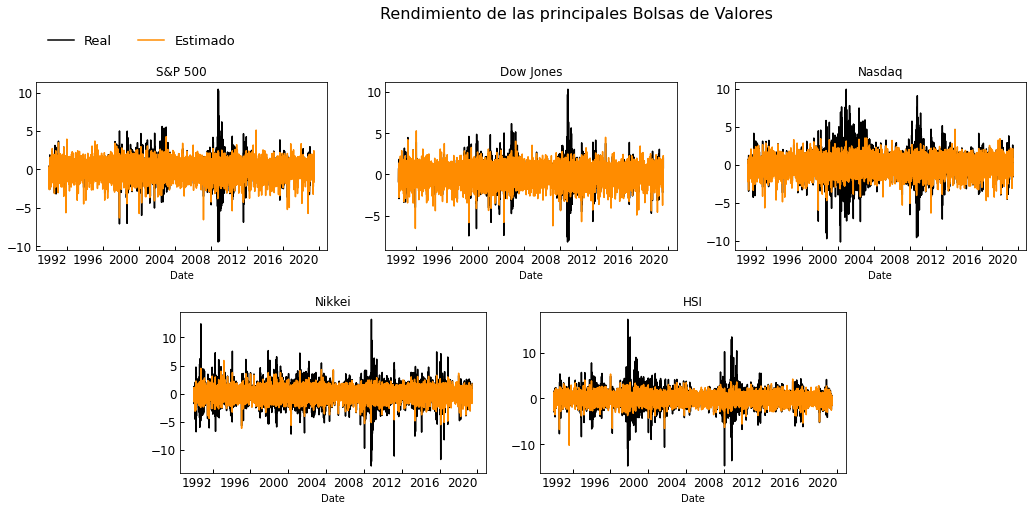

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(25, 8))
ax[1, 2].set_visible(False) # No habrá 6to subplot

fig.suptitle("Rendimiento de las principales Bolsas de Valores", fontsize=16, y=0.93)


# Subplots:
Y["S&P 500"].plot(color="black", ax=ax[0, 0], label="Real")
sp_model.std_resid.plot(color="darkorange", ax=ax[0, 0], label="Estimado")
ax[0, 0].set_title("S&P 500")
ax[0, 0].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

Y["Dow Jones"].plot(color="black", ax=ax[0, 1])
dj_model.std_resid.plot(color="darkorange", ax=ax[0, 1])
ax[0, 1].set_title("Dow Jones")
ax[0, 1].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

Y["Nasdaq"].plot(color="black", ax=ax[0, 2])
nq_model.std_resid.plot(color="darkorange", ax=ax[0, 2])
ax[0, 2].set_title("Nasdaq")
ax[0, 2].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

Y["Nikkei"].plot(color="black", ax=ax[1, 0])
nk_model.std_resid.plot(color="darkorange", ax=ax[1, 0])
ax[1, 0].set_title("Nikkei")
ax[1, 0].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

Y["HSI"].plot(color="black", ax=ax[1, 1])
hsi_model.std_resid.plot(color="darkorange", ax=ax[1, 1])
ax[1, 1].set_title("HSI")
ax[1, 1].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

ax[0, 0].legend(bbox_to_anchor=(0, 1.35), ncol=2, loc = 'upper left', fontsize=13, frameon=False)
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

# Posiciones de los subplots de la segunda fila
ax[1, 0].set_position([0.28, 0.12, 0.17, 0.28]) 
ax[1, 1].set_position([0.48, 0.12, 0.17, 0.28])

plt.show()

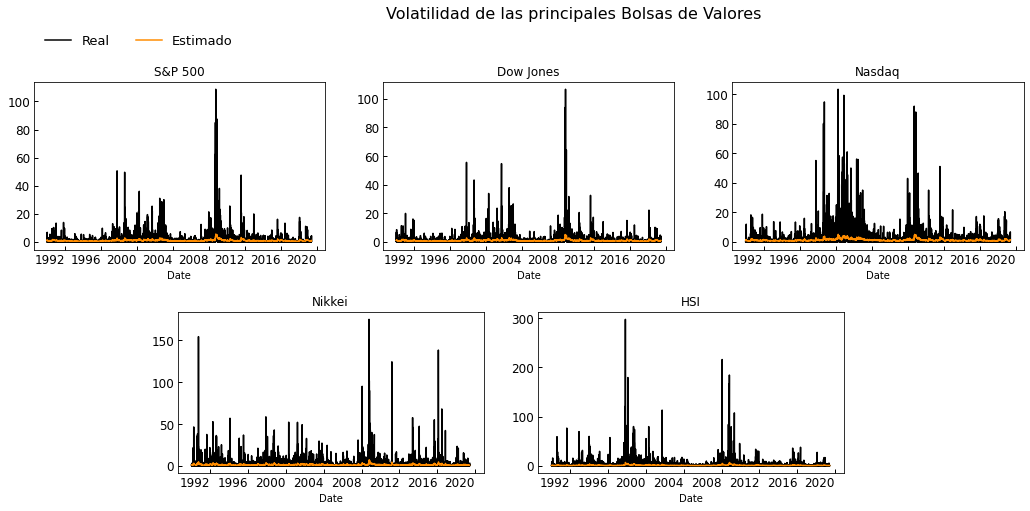

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(25, 8))
ax[1, 2].set_visible(False) # No habrá 6to subplot

fig.suptitle("Volatilidad de las principales Bolsas de Valores", fontsize=16, y=0.93)

# Subplots:
volat["S&P 500"].plot(color="black", ax=ax[0, 0], label="Real")
sp_model.conditional_volatility.plot(color="darkorange", ax=ax[0, 0], label="Estimado")
ax[0, 0].set_title("S&P 500")
ax[0, 0].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

volat["Dow Jones"].plot(color="black", ax=ax[0, 1])
dj_model.conditional_volatility.plot(color="darkorange", ax=ax[0, 1])
ax[0, 1].set_title("Dow Jones")
ax[0, 1].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

volat["Nasdaq"].plot(color="black", ax=ax[0, 2])
nq_model.conditional_volatility.plot(color="darkorange", ax=ax[0, 2])
ax[0, 2].set_title("Nasdaq")
ax[0, 2].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

volat["Nikkei"].plot(color="black", ax=ax[1, 0])
nk_model.conditional_volatility.plot(color="darkorange", ax=ax[1, 0])
ax[1, 0].set_title("Nikkei")
ax[1, 0].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

volat["HSI"].plot(color="black", ax=ax[1, 1])
hsi_model.conditional_volatility.plot(color="darkorange", ax=ax[1, 1])
ax[1, 1].set_title("HSI")
ax[1, 1].tick_params(direction='in', which='both', length=4, width=1, labelsize=12, rotation=0)

ax[0, 0].legend(bbox_to_anchor=(0, 1.35), ncol=2, loc = 'upper left', fontsize=13, frameon=False)
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)

# Posiciones de los subplots de la segunda fila
ax[1, 0].set_position([0.28, 0.12, 0.17, 0.28]) 
ax[1, 1].set_position([0.48, 0.12, 0.17, 0.28])

plt.show()

El modelo GARCH, si bien nos presenta resultados aproximados a los reales para los retornos, es un modelo un poco simple comparado a nuevas metodologías. Actualmente, se cuenta con una gran variedad de modelos. Entre ellos modelos asimétricos que -mediante una distribución t-student- capturan las colas pesadas. Queda pendiente realizar una estimación con algún mejor modelo